# Photon ID Run 2 BDT classification

In [7]:
import uproot
import numpy as np
import pandas as pd
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

#import mplhep as hep
#hep.style.use("ATLAS")

import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay

import joblib

import seaborn as sns

In [5]:
datadir = "/lapp_data/atlas/perf-egamma/InclusivePhotons/fullRun2/FinalNtuples/"

In [6]:
df_sig = pd.read_pickle(datadir+"Py8_yj_mc16ade_pd122_train_w.pkl")
df_bkg = pd.read_pickle(datadir+"Py8_jj_mc16ade_pd122_train_w.pkl")

SystemError: deallocated bytearray object has exported buffers

MemoryError: 

In [4]:
shower_shape_var = ['y_Reta',
                    'y_Rphi',
                    'y_weta2',
                    'y_fracs1',
                    'y_weta1',
                    'y_wtots1',
                    'y_Rhad',
                    'y_Rhad1',
                    'y_Eratio', 
                    'y_deltae']

conv_var = [ 'y_convRadius', 'y_convType']

kinem_var = ['y_pt', 'y_eta', 'y_phi']

#truth_var = ['y_truth_pt', 'y_truth_eta', 'y_truth_pdgId', 'y_truth_mother_pdgId' ]
truth_var = ['y_truth_pt', 'y_truth_eta' ]

discriminating_var = shower_shape_var + kinem_var + conv_var 
discriminating_var

['y_Reta',
 'y_Rphi',
 'y_weta2',
 'y_fracs1',
 'y_weta1',
 'y_wtots1',
 'y_Rhad',
 'y_Rhad1',
 'y_Eratio',
 'y_deltae',
 'y_pt',
 'y_eta',
 'y_phi',
 'y_convRadius',
 'y_convType']

In [5]:
len(df_sig)

38961840

### Select only photons from hard scattering in signal sample

In [6]:
np.unique(df_sig['y_truth_origin'])

array([37.], dtype=float32)

In [7]:
np.unique(df_sig['y_truth_type'])

array([14.], dtype=float32)

In [8]:
# Not needed, already selected in previous step
# df_sig = df_sig.query('y_truth_type == 14')

In [9]:
print('Number of selected signal events     : ', len(df_sig))
print('Number of selected background events : ', len(df_bkg))
print('Number of selected weighted signal events     : ', sum(df_sig['mcTotWeight']))
print('Number of selected weighted background events : ', sum(df_bkg['totWeight']))

Number of selected signal events     :  38961840
Number of selected background events :  19277763
Number of selected weighted signal events     :  12041956366.836224
Number of selected weighted background events :  12041956366.832306


### Plot $\eta$ and $p_T$ distributions

[]

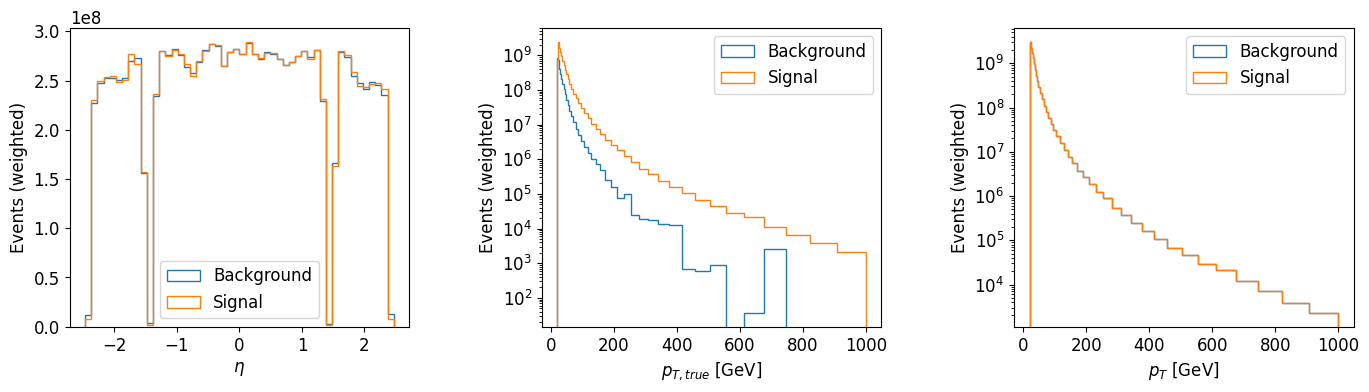

In [10]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize = (15, 5))
fig.tight_layout(pad = 5.0)

eta_bins = np.linspace(-2.47, 2.47,50+1)

_ = ax1.hist(df_bkg['y_eta'], weights=df_bkg['totWeight'], #density=True,
             histtype = 'step', bins=eta_bins, label='Background')

_ = ax1.hist(df_sig['y_eta'], weights=df_sig['mcTotWeight'], #density=True,
             histtype = 'step', bins=eta_bins, label='Signal')

ax1.set_xlabel('$\eta$')
ax1.set_ylabel('Events (weighted)')
ax1.legend()
ax1.plot()

ptmin = 20
ptmax = 1000
nbins = 40
x = np.linspace(np.log(ptmin),np.log(ptmax),nbins+1)
pt_bins = np.exp(x)

_ = ax2.hist(df_bkg['y_truth_pt'], weights=df_bkg['totWeight'], #density=True,
             histtype='step', log=True, bins=pt_bins, label='Background')

_ = ax2.hist(df_sig['y_truth_pt'], weights=df_sig['mcTotWeight'], #density=True,
             histtype='step', log=True, bins=pt_bins, label='Signal')

ax2.set_xlabel('$p_{T,true}$ [GeV]')
ax2.set_ylabel('Events (weighted)')
ax2.legend()
ax2.plot()

_ = ax3.hist(df_bkg['y_pt'], weights=df_bkg['totWeight'], #density=True,
             histtype='step', log=True, bins=pt_bins, label='Background')

_ = ax3.hist(df_sig['y_pt'], weights=df_sig['mcTotWeight'], #density=True,
             histtype='step', log=True, bins=pt_bins, label='Signal')

ax3.set_xlabel('$p_{T}$ [GeV]')
ax3.set_ylabel('Events (weighted)')
ax3.legend()
ax3.plot()

### Prepare samples for training

In [11]:
# truth_label = 1 ==>> signal (photons)
# truth_label = 0 ==>> background (jets)

df_sig["truth_label"]=1.
df_bkg["truth_label"]=0.

df_sig["weight"]=df_sig['mcTotWeight']
df_bkg["weight"]=df_bkg["totWeight"]

# remove unused columns from training dataframe
col_sig = ['evtWeight','intLumi', 'xs', 'ge', 'mcWeight', 'lumiXsecWeight', 'lumiXsecWeightOriginal', 'xsecWeight', 'mcTotWeight', 'sumWeights']
for c in col_sig:
    df_sig.drop(c, axis=1, inplace=True)

col_bkg = ['evtWeight','intLumi', 'xs', 'ge', 'mcWeight', 'lumiXsecWeight', 'lumiXsecWeightOriginal', 'xsecWeight', 'mcTotWeight', 'sumWeights','etaWeight', 'ptWeight', 'totWeight', ]
for c in col_bkg:
    df_bkg.drop(c, axis=1, inplace=True)

totald = pd.concat([df_sig, df_bkg], axis=0)

In [12]:
totald.head()

,y_Reta,y_Rphi,y_weta2,y_fracs1,y_weta1,y_emaxs1,y_f1,y_wtots1,y_Rhad,y_Rhad1,...,y_truth_eta,y_truth_phi,y_truth_e,y_truth_type,y_truth_origin,y_truth_pdgId,y_truth_mother_pdgId,evt_mu,truth_label,weight
0,0.955283,0.721005,0.016857,0.248116,0.602672,-999.0,0.370115,6.163973,-0.007951,-0.011676,...,0.719087,1.930389,20.873417,14.0,37.0,22,22,26.49,1.0,71524.424963
1,0.973579,0.976123,0.010848,0.250266,0.628516,-999.0,0.179565,1.934841,-0.003076,0.005439,...,1.269462,3.105107,31.526150,14.0,37.0,22,22,34.50,1.0,39869.825713
2,0.971119,0.937279,0.010630,0.315495,0.622121,-999.0,0.420247,2.084521,-0.011601,-0.003843,...,0.544353,-2.854456,18.565092,14.0,37.0,22,22,25.50,1.0,60688.599349
3,0.988873,0.911961,0.011643,0.285961,0.614036,-999.0,0.277960,2.518094,-0.004840,-0.004938,...,-1.207192,2.729292,29.307465,14.0,37.0,22,22,32.50,1.0,60355.225420
4,0.955146,0.924300,0.011432,0.297172,0.602380,-999.0,0.377742,2.150100,-0.011881,-0.011621,...,0.763746,-1.044832,30.490871,14.0,37.0,22,22,33.50,1.0,44774.051784


In [13]:
totald.to_pickle(datadir+"Py8_yj_jj_mc16ade_pd122_train_w.pkl")

In [3]:
totald = pd.read_pickle(datadir+"Py8_yj_jj_mc16ade_pd122_train_w_skim.pkl")

MemoryError: 

In [ ]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(10,10))
fig.tight_layout(pad = 5.0)

reta_bins = eta_bins = np.linspace(0,1,50+1)

_ = ax1.hist(totald[(totald["truth_label"]==0)]['y_Reta'], 
             weights=totald[(totald["truth_label"]==0)]['weight'], density=True,
             histtype='stepfilled', log=True, bins=reta_bins, alpha=0.5, label='Background')

_ = ax1.hist(totald[(totald["truth_label"]==1)]['y_Reta'], 
             weights=totald[(totald["truth_label"]==1)]['weight'], density=True,
             histtype='stepfilled', log=True, bins=reta_bins, alpha=0.5, label='Signal')

ax1.set_xlabel(r"$R_{\eta}$")
ax1.set_ylabel(r"Frequency")
ax1.legend()
ax1.plot()

rphi_bins = eta_bins = np.linspace(0,1,50+1)

_ = ax2.hist(totald[(totald["truth_label"]==0)]['y_Rphi'], 
             weights=totald[(totald["truth_label"]==0)]['weight'], density=True,
             histtype='stepfilled', log=True, bins=rphi_bins, alpha=0.5, label='Background')

_ = ax2.hist(totald[(totald["truth_label"]==1)]['y_Rphi'], 
             weights=totald[(totald["truth_label"]==1)]['weight'], density=True,
             histtype='stepfilled', log=True, bins=rphi_bins, alpha=0.5, label='Signal')

ax2.set_xlabel(r"$R_{\phi}$")
ax2.set_ylabel(r"Frequency")
ax2.legend()
ax2.plot()


_ = ax3.hist(totald[(totald["truth_label"]==0)]['y_fracs1'], 
             weights=totald[(totald["truth_label"]==0)]['weight'], density=True,
             histtype='stepfilled', log=True, bins=np.linspace(0,1,50+1), alpha=0.5, label='Background')

_ = ax3.hist(totald[(totald["truth_label"]==1)]['y_fracs1'], 
             weights=totald[(totald["truth_label"]==1)]['weight'], density=True,
             histtype='stepfilled', log=True, bins=np.linspace(0,1,50+1), alpha=0.5, label='Signal')

ax3.set_xlabel(r"$f_{S1}$")
ax3.set_ylabel(r"Frequency")
ax3.legend()
ax3.plot()


_ = ax4.hist(totald[(totald["truth_label"]==0)]['y_Eratio'], 
             weights=totald[(totald["truth_label"]==0)]['weight'], density=True,
             histtype='stepfilled', log=True, bins=np.linspace(0,1,50+1), alpha=0.5, label='Background')

_ = ax4.hist(totald[(totald["truth_label"]==1)]['y_Eratio'], 
             weights=totald[(totald["truth_label"]==1)]['weight'], density=True,
             histtype='stepfilled', log=True, bins=np.linspace(0,1,50+1), alpha=0.5, label='Signal')

ax4.set_xlabel(r"$E_{ratio}$")
ax4.set_ylabel(r"Frequency")
ax4.legend()
ax4.plot()

### Prepare inputs for training

* `discriminating_var` containes the features used in the training
* Weights are added Y column to be able to access them after splitting in train and test samples.
* `test_size` represents the proportion of the dataset to include in the test split

In [16]:
discriminating_var

['y_Reta',
 'y_Rphi',
 'y_weta2',
 'y_fracs1',
 'y_weta1',
 'y_wtots1',
 'y_Rhad',
 'y_Rhad1',
 'y_Eratio',
 'y_deltae',
 'y_pt',
 'y_eta',
 'y_phi',
 'y_convRadius',
 'y_convType']

In [17]:
set(totald.columns)-set(discriminating_var)

{'evt_mu',
 'truth_label',
 'weight',
 'y_IsLoose',
 'y_IsTight',
 'y_e',
 'y_e277',
 'y_emaxs1',
 'y_f1',
 'y_iso_FixedCutLoose',
 'y_iso_FixedCutTight',
 'y_jmin_dr',
 'y_noFF_Eratio',
 'y_noFF_Reta',
 'y_noFF_Rhad',
 'y_noFF_Rhad1',
 'y_noFF_Rphi',
 'y_noFF_deltae',
 'y_noFF_e277',
 'y_noFF_emaxs1',
 'y_noFF_f1',
 'y_noFF_fracs1',
 'y_noFF_weta1',
 'y_noFF_weta2',
 'y_noFF_wtots1',
 'y_ptcone20',
 'y_ptcone40',
 'y_topoetcone20',
 'y_topoetcone40',
 'y_truth_e',
 'y_truth_eta',
 'y_truth_mother_pdgId',
 'y_truth_origin',
 'y_truth_pdgId',
 'y_truth_phi',
 'y_truth_pt',
 'y_truth_type'}

In [18]:
Y_var = ["truth_label",
         "weight",
         'y_IsTight',
         'y_IsLoose',
         'y_iso_FixedCutLoose',
         'y_iso_FixedCutTight',
         'y_topoetcone20', 
         'y_topoetcone40',
         'evt_mu', 
         'y_jmin_dr']

Y_var

['truth_label',
 'weight',
 'y_IsTight',
 'y_IsLoose',
 'y_iso_FixedCutLoose',
 'y_iso_FixedCutTight',
 'y_topoetcone20',
 'y_topoetcone40',
 'evt_mu',
 'y_jmin_dr']

### Step 0: Save X and Y datasets with relevant variables

* Adding truth variables to X for performance studies, will be removed after splitting

In [19]:
X = totald[discriminating_var+truth_var]
Y = totald[Y_var]

### Step 1: Split dataset into train, validation and test samples

* Test dataset size: 20 %

In [20]:
x_train_val, x_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Step 2: Split train + validation set into train and validation

* Train and validation are respectively 80% and 20% of 80% of total

In [21]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, random_state=42)

In [22]:
wdf_train = pd.DataFrame({"weight"             : y_train["weight"] ,
                          "y_IsTight"          : y_train['y_IsTight'], 
                          'y_IsLoose'          : y_train['y_IsLoose'], 
                          'y_iso_FixedCutLoose': y_train['y_iso_FixedCutLoose'], 
                          'y_iso_FixedCutTight': y_train['y_iso_FixedCutTight'], 
                          'y_topoetcone20'     : y_train['y_topoetcone20'], 
                          'y_topoetcone40'     : y_train['y_topoetcone40'], 
                          'evt_mu'             : y_train['evt_mu'], 
                          'y_jmin_dr'          : y_train['y_jmin_dr']})

In [23]:
wdf_test  = pd.DataFrame({"weight"             : y_test["weight"] ,
                          "y_IsTight"          : y_test['y_IsTight'], 
                          'y_IsLoose'          : y_test['y_IsLoose'], 
                          'y_iso_FixedCutLoose': y_test['y_iso_FixedCutLoose'], 
                          'y_iso_FixedCutTight': y_test['y_iso_FixedCutTight'], 
                          'y_topoetcone20'     : y_test['y_topoetcone20'], 
                          'y_topoetcone40'     : y_test['y_topoetcone40'], 
                          'evt_mu'             : y_test['evt_mu'], 
                          'y_jmin_dr'          : y_test['y_jmin_dr']})

In [24]:
wdf_val = pd.DataFrame({"weight"             : y_val["weight"] ,
                        "y_IsTight"          : y_val['y_IsTight'], 
                        'y_IsLoose'          : y_val['y_IsLoose'], 
                          'y_iso_FixedCutLoose': y_val['y_iso_FixedCutLoose'], 
                          'y_iso_FixedCutTight': y_val['y_iso_FixedCutTight'], 
                          'y_topoetcone20'     : y_val['y_topoetcone20'], 
                          'y_topoetcone40'     : y_val['y_topoetcone40'], 
                          'evt_mu'             : y_val['evt_mu'], 
                          'y_jmin_dr'          : y_val['y_jmin_dr']})

In [25]:
truth_train = pd.DataFrame({"y_truth_pt" : x_train['y_truth_pt'], 
                            "y_truth_eta": x_train['y_truth_eta']})

truth_val   = pd.DataFrame({"y_truth_pt" : x_val['y_truth_pt'], 
                            "y_truth_eta": x_val['y_truth_eta']})

truth_test  = pd.DataFrame({"y_truth_pt" : x_test['y_truth_pt'], 
                            "y_truth_eta": x_test['y_truth_eta']})

In [26]:
truth_var_drop = list(set(y_train.columns)-{'truth_label'})
truth_var_drop

['y_IsLoose',
 'weight',
 'y_iso_FixedCutLoose',
 'y_IsTight',
 'y_iso_FixedCutTight',
 'y_topoetcone20',
 'y_jmin_dr',
 'y_topoetcone40',
 'evt_mu']

In [27]:
y_train = y_train.drop(truth_var_drop, axis=1)
y_test  = y_test.drop(truth_var_drop, axis=1)
y_val   = y_val.drop(truth_var_drop, axis=1)

In [28]:
# This is crucial: we don't want to use truth variables as training features!
x_train = x_train.drop(truth_var, axis=1)
x_test  = x_test.drop(truth_var, axis=1)
x_val   = x_val.drop(truth_var, axis=1)

In [29]:
print('TRAINING   size = {:8d}'.format(len(y_train)))
print('TEST       size = {:8d}'.format(len(y_test)))
print('VALIDATION size = {:8d}'.format(len(y_val)))

TRAINING   size = 37273345
TEST       size = 11647921
VALIDATION size =  9318337


In [30]:
print('Number of signal events in test sample     :', len(y_test.query('truth_label == True')))
print('Number of background events in test sample :', len(y_test.query('truth_label == False')))

Number of signal events in test sample     : 7793480
Number of background events in test sample : 3854441


In [31]:
y_train = np.ravel(y_train)
y_val = np.ravel(y_val)

weight_train = np.array(wdf_train["weight"])
weight_val = [np.array(wdf_train["weight"]), np.array(wdf_val["weight"])]

### BDT training

In [32]:
model = lgb.LGBMClassifier(learning_rate=0.05,  
                           num_leaves=35,
                           max_depth=-5,
                           objective='xentropy',
                           n_estimators=1000,
                           force_col_wise=True)

cb = [lgb.early_stopping(stopping_rounds=10),lgb.log_evaluation(30)]

model.fit(x_train, y_train,
          eval_set = [(x_train, y_train), (x_val, y_val)],  
          eval_names = ['Train', 'Validation'],
          eval_metric = 'xentropy', 
          sample_weight = weight_train,
          eval_sample_weight = weight_val,
          callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(30)])

[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 14744675328.000000
[LightGBM] [Info] Total Bins 3576
[LightGBM] [Info] Number of data points in the train set: 37273345, number of used features: 15
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 3832183296.000000
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.500203 -> initscore = 0.000813
[LightGBM] [Info] Start training from score 0.000813
Training until validation scores don't improve for 10 rounds
[30]	Train's cross_entropy: 0.317029	Validation's cross_entropy: 0.304856
[60]	Train's cross_entropy: 0.257255	Validation's cross_entropy: 0.247573
[90]	Train's cross_entropy: 0.241336	Validation's cross_entropy: 0.232631
[120]	Train's cross_entropy: 0.2346

LGBMClassifier(force_col_wise=True, learning_rate=0.05, max_depth=-5,
               n_estimators=1000, num_leaves=35, objective='xentropy')

In [33]:
# Saving model to file
joblib.dump(model,'models/LGBMClassifier_model_hard_no_loose_lr0.05_35.pkl')

['models/LGBMClassifier_model_hard_no_loose_lr0.05_35.pkl']

### Feature importance

In [51]:
# Loading model from file
model_pickle = joblib.load('models/LGBMClassifier_model_hard_no_loose_lr0.05_35.pkl')

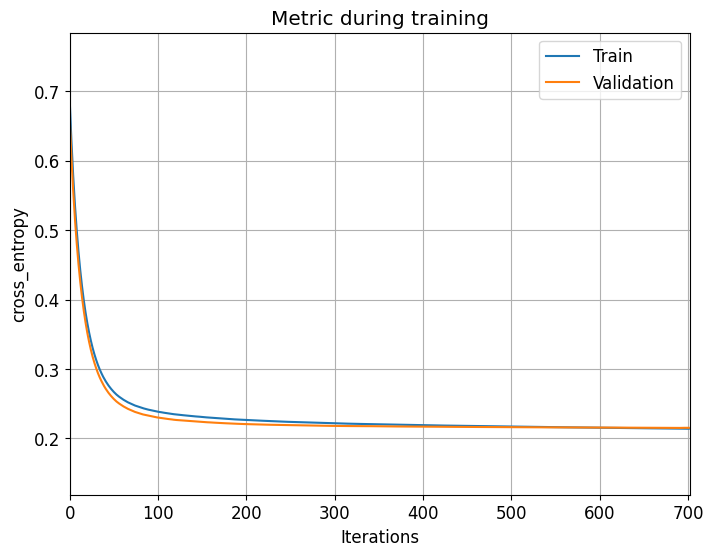

In [52]:
# Cross-entropy evolution during training
lgb.plot_metric(model_pickle, figsize=(8,6))
plt.title('Metric during training')
plt.savefig('plots/metric_lr_0.09_35.pdf')

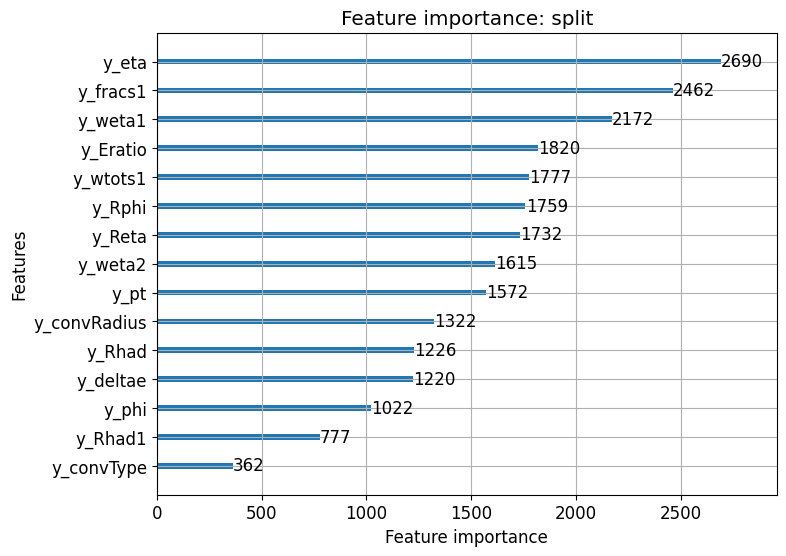

In [53]:
# Feature importance: Numbers of times the feature is used in a model
lgb.plot_importance(model_pickle, importance_type='split', figsize=(8,6))
plt.title('Feature importance: split')
plt.savefig('plots/feature_split_lr_0.09_35.pdf')
plt.show()

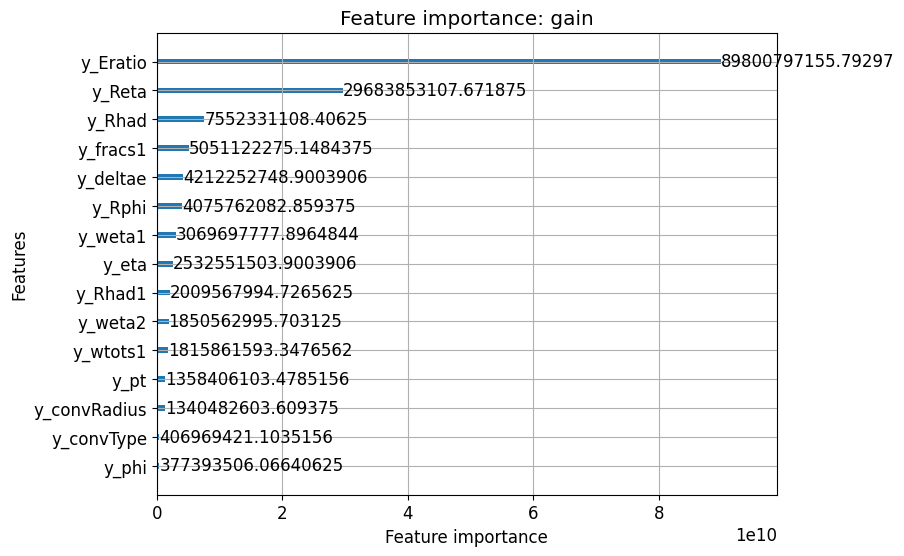

In [54]:
lgb.plot_importance(model_pickle, importance_type='gain', precision = None, figsize=(8,6))
plt.title('Feature importance: gain')
plt.savefig('plots/feature_gain_lr_0.09_35.pdf')
plt.show()

### Dataset with signal & background scores

In [55]:
# make predictions to the test sample
y_pred_prob = model_pickle.predict_proba(x_test)
y_pred_prob_train = model_pickle.predict_proba(x_train)

In [56]:
y_test = pd.DataFrame(y_test)
y_train = pd.DataFrame(y_train)

In [57]:
wdf_test.head()

,weight,y_IsTight,y_IsLoose,y_iso_FixedCutLoose,y_iso_FixedCutTight,y_topoetcone20,y_topoetcone40,evt_mu,y_jmin_dr
0,4.248286,True,True,True,False,2.826097,12.113009,26.490000,3.130468e+00
1,0.175998,True,True,True,True,-0.324756,1.044672,28.490000,1.973612e+00
2,29.921994,True,True,True,True,-0.729677,-1.365169,15.500000,8.998119e-01
3,631.878759,False,True,True,True,0.241984,2.550226,34.490002,2.859316e+00
4,47.314782,True,True,True,True,-1.819142,-1.538420,25.490000,8.999999e+09


In [58]:
df = pd.DataFrame(y_pred_prob, columns=['0', '1']) # test sample predictions
dg = pd.DataFrame(y_pred_prob_train, columns = ['0', '1'])

df.reset_index(inplace=True, drop=True)
dg.reset_index(inplace=True, drop=True)

y_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)

wdf_test.reset_index(inplace=True, drop=True)
wdf_train.reset_index(inplace=True, drop=True)

In [59]:
df2 = pd.concat([df, y_test, wdf_test], axis=1, join='inner', ignore_index=True)
dg2 = pd.concat([dg, y_train, wdf_train], axis=1, join='inner', ignore_index=True)

In [61]:
col_names = ["background_score", "signal_score"] + list(y_test.columns) + list(wdf_test.columns)
df2.columns = col_names
dg2.columns = col_names

In [121]:
xf2 = x_test[kinem_var + conv_var]
xf2.reset_index(inplace=True, drop=True)
df_test_all = pd.concat([xf2,df2], axis=1, join='inner', ignore_index=True)
df_test_all.columns = list(xf2.columns)+list(df2.columns)
df_test_all

,y_pt,y_eta,y_phi,y_convRadius,y_convType,background_score,signal_score,truth_label,weight,y_IsTight,y_IsLoose,y_iso_FixedCutLoose,y_iso_FixedCutTight,y_topoetcone20,y_topoetcone40,evt_mu,y_jmin_dr
0,161.701477,0.362196,2.487155,629.981873,2,0.021797,0.978203,1.0,4.248286,True,True,True,False,2.826097,12.113009,26.490000,3.130468e+00
1,385.804260,1.128969,-1.012413,306.678284,5,0.030782,0.969218,1.0,0.175998,True,True,True,True,-0.324756,1.044672,28.490000,1.973612e+00
2,103.813927,-1.250267,-1.753746,9999.000000,0,0.018690,0.981310,1.0,29.921994,True,True,True,True,-0.729677,-1.365169,15.500000,8.998119e-01
3,49.413609,1.750125,0.338590,646.382996,2,0.050701,0.949299,1.0,631.878759,False,True,True,True,0.241984,2.550226,34.490002,2.859316e+00
4,71.762466,1.366162,1.486376,9999.000000,0,0.022225,0.977775,1.0,47.314782,True,True,True,True,-1.819142,-1.538420,25.490000,8.999999e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11647916,38.508072,0.000841,2.667011,9999.000000,0,0.282313,0.717687,1.0,605.255185,False,True,False,False,25.190548,25.245129,30.490000,2.798115e+00
11647917,62.421371,-0.070698,-2.724728,86.245285,3,0.264801,0.735199,1.0,145.246860,True,True,True,True,1.110601,-1.597132,20.500000,3.151037e+00
11647918,23.128321,-0.174299,-1.980171,577.424744,2,0.996355,0.003645,0.0,214.826269,False,False,False,False,8.654372,7.245803,47.500000,8.999999e+09
11647919,541.316162,-1.528473,-2.291253,9999.000000,0,0.037181,0.962819,1.0,0.020814,True,True,True,True,3.105390,6.861549,37.500000,2.373017e+00


In [122]:
df_test_all.to_pickle(datadir+"test_sample_hard_scattering.pkl")

### BDT output

The BDT output has two columns: for each event a score (probability) to belong to class 0 or class 1  (here they are called `background_class` and `signal_class` ) is assigned.

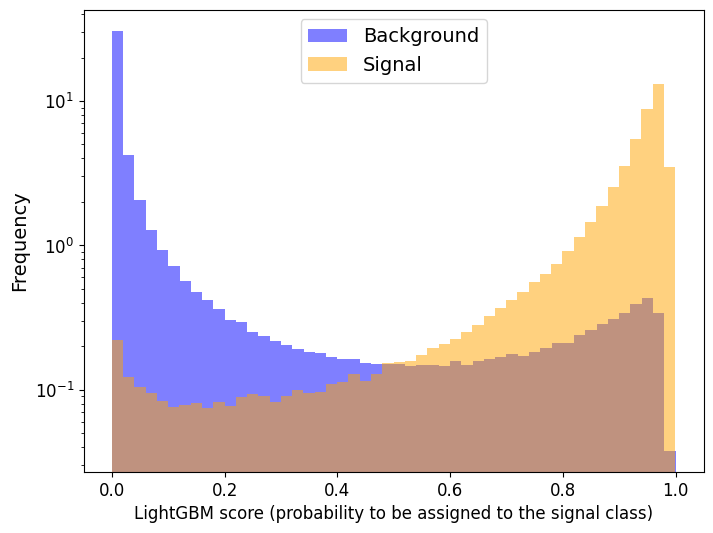

In [63]:
fig, ax = plt.subplots(figsize=(8,6))

plt.hist(df2[(df2["truth_label"]==0 )]["signal_score"],
         weights = df2[(df2["truth_label"]==0 )]["weight"], 
         bins = 50, log = True, density = True, alpha=0.5, 
         histtype = 'stepfilled', label='Background', color = 'b')

plt.hist(df2[(df2["truth_label"]==1 )]["signal_score"],
         weights = df2[(df2["truth_label"]==1 )]["weight"], 
         bins = 50, log = True, density = True, alpha=0.5,
         histtype = 'stepfilled', label='Signal', color = 'orange')

plt.ylabel('Frequency', fontsize = 14)

plt.legend(loc='upper center', fontsize = 14)
plt.gca().set(xlabel="LightGBM score (probability to be assigned to the signal class)")

plt.savefig('plots/score_lr_0.09_35.pdf')
plt.show()

### ROC curve

1) compute signal and background efficiencies for "official" cut-based Tight selection

In [64]:
s_tot = sum( df2[(df2["truth_label"] == 1)]["weight"] )
s_selected = sum( df2[(df2["truth_label"] == 1) & (df2['y_IsTight'].values)]["weight"] )
s_eff = s_selected / s_tot

b_tot = sum( df2[(df2["truth_label"] == 0)]["weight"] )
b_selected = sum( df2[(df2["truth_label"] == 0) & (df2['y_IsTight'].values)]["weight"] )
b_eff = b_selected / b_tot

In [83]:
print(f"Number of signal events                   = {s_tot:12.0f}")
print(f"Number of signal events passing Tight     = {s_selected:12.0f}")
print(f"Signal efficiency of cut-based Tight      = {100.*s_selected/s_tot:11.2f}%" )
print()
print(f"Number of background events               = {b_tot:12.0f}")
print(f"Number of background events passing Tight = {b_selected:12.0f}")
print(f"Background efficiency of cut-based Tight  = {100.*b_selected/b_tot:11.2f}%" )
print(f"Background rejection of cut-based Tight   = {100.*(1-b_selected/b_tot):11.2f}%" )

Number of signal events                   =   2404139444
Number of signal events passing Tight     =   1932834106
Signal efficiency of cut-based Tight      =       80.40%

Number of background events               =   2408937683
Number of background events passing Tight =    153631191
Background efficiency of cut-based Tight  =        6.38%
Background rejection of cut-based Tight   =       93.62%


2) Plot ROC curve of trained BDT with weighted events, compare to current cut-based Tight selection 

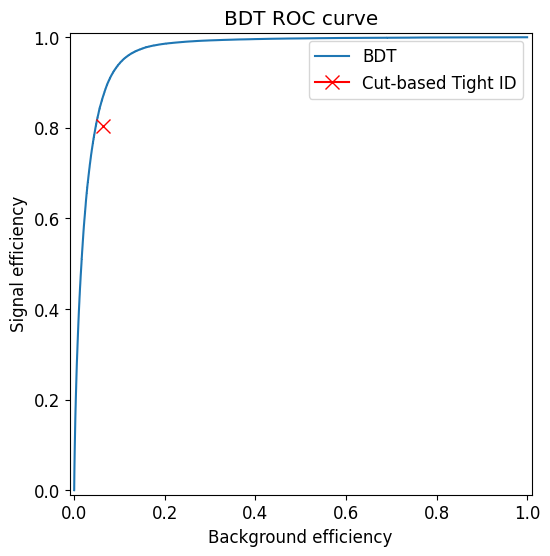

In [86]:
fig, ax = plt.subplots(figsize=(8,6))

mod_disp = RocCurveDisplay.from_estimator(model_pickle, x_test, y_test, sample_weight=df2["weight"], 
                                          label="BDT", ax=ax) 

plt.plot(b_eff, s_eff, marker="x", markersize=10, color="red", label = 'Cut-based Tight ID')

plt.xlabel('Background efficiency')
plt.ylabel('Signal efficiency')

#plt.xlim([0.0, 0.15])
#plt.ylim([0.65, 1.0])
#plt.title('BDT ROC curve - zoom')

plt.title('BDT ROC curve')
plt.legend()

plt.savefig('plots/ROC_lr_0.05_35_weight.pdf')
plt.show()

### Correlation between input variables

In [48]:
#x_train_sel = x_train.query('y_wtots1 >- 800 & y_weta1 > -800')
#x_train_sel.reset_index(inplace=True, drop=True)

In [91]:
corr = x_train.corr()

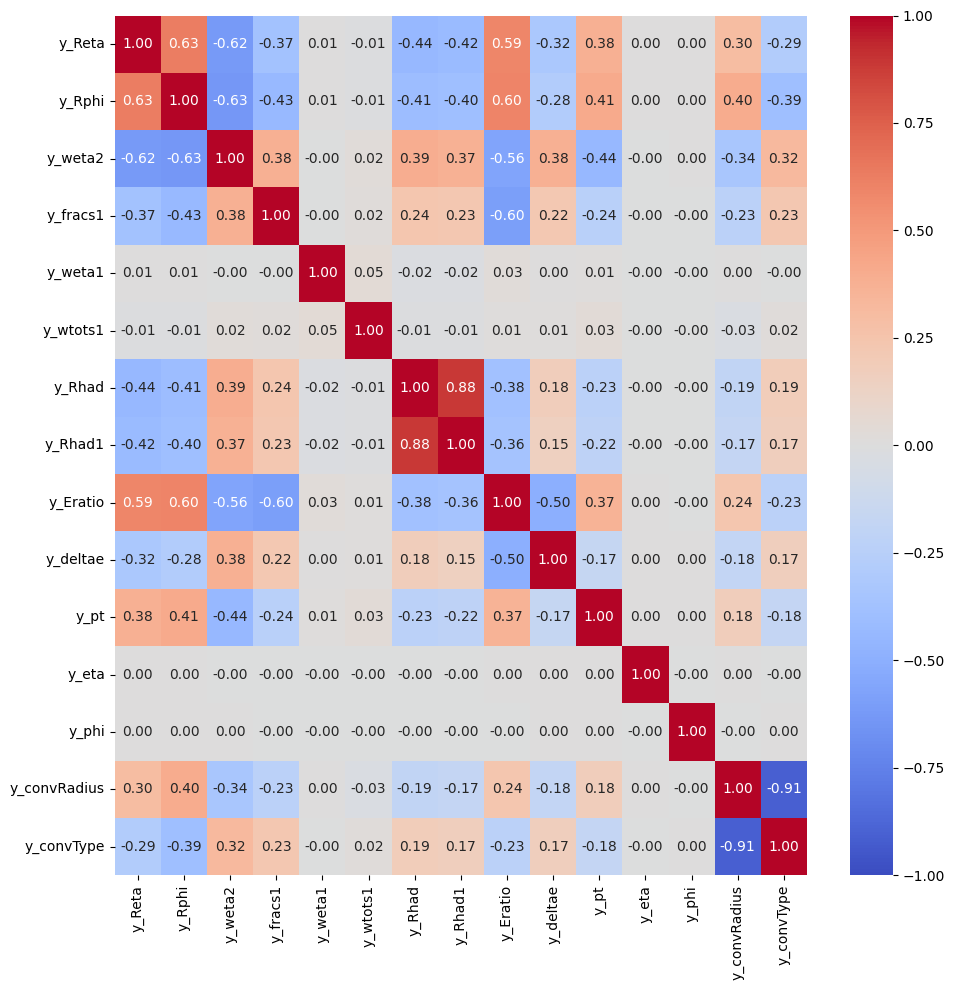

In [100]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.rcParams.update({'font.size': 10})

sns.heatmap(corr, vmin=-1, vmax=1, cmap="coolwarm", ax=ax, annot=True, fmt=".2f")

plt.tight_layout()
plt.savefig('plots/correlations_train_sample_all.pdf')
plt.show()

In [94]:
#corr_sig = x_train[(y_train==1)].corr()
#corr_bkg = x_train[(y_train==0)].corr()